**<font size="5">Treino com os dados do Titanic</font>**

Um dos naufrágios mais infames da história é o do Titanic, que afundou após colidir com um iceberg. Infelizmente, não havia botes salva-vidas suficientes para todos a bordo, resultando na morte de 1502 dos 2224 passageiros e tripulantes.

Embora houvesse algum elemento de sorte envolvido na sobrevivência, parece que alguns grupos de pessoas eram mais propensos a sobreviver do que outros. **O desafio aqui é construir um modelo preditivo que discrimine os grupos de pessoas com maiores chances de sovreviver.**

**<font size="3">Principais objetivos</font>**: 
- Me familiarizar com a plataforma Kaggle e suas competições.
- Desenvolver e colocar em prática técnicas de EDA
- Resolver o problema e buscar melhorar a pontuação baseando-se em metodos e ideias que vi em notebooks compartilhados por cientistas de dados da comunidade mais experientes.

**<font size="5">Importando dados e bibliotecas necessárias</font>**

In [1]:
# análise e transformação dos dados
import pandas as pd
import numpy as np
import random as rnd

# visualização
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.base import clone 

In [2]:
# importando os datasets

import os

train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
all_data = train_df.append(test_df, sort=True);

In [3]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


**<font size="5">Análise exploratória</font>**

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Madigan, Miss. Margaret ""Maggie""",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [6]:
# Número de "NaN"s em cada feature
print(all_data.shape)
all_data.isnull().sum().drop('Survived')

(1309, 12)


Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Ticket            0
dtype: int64

**<font size="3">Observações</font>**:
- Cinco features são nominais, das quais apenas "Sex" e "Embarked" possuem poucos valores únicos e podem ser facilmente convertidas em variáveis numéricas ordinais/discretas.

- Proporção de "Missing values" encontrados: "Cabin" 77%  >>> "Age" 20% >> "Embarked" apenas 2 > "Fare" apenas 1.

- A chance de sobrvivência média do conjunto de dados é de 38% e está próxima da taxa real de 32% (1-1502/2224). Também pode ser usado como parâmetro de comparação para o impacto de determinadas features.

**<font size="3">Especulações</font>**:
- PassangerId, Ticket e Name provavelmente não contribuem para a sobrevivência, descartá-los logo no início é conveniente pois reduz o volume de dados, acelera o processamento do código e simplifica a análise, mas vale ressaltar que o nome também possui informações sobre o título do passageiro, extraír isso em uma nova feature pode beneficiar a acuracia do modelo.

- Uma possibilidade para haver tantos valores nulos para a cabine é que isso pode representar uma luxúria de alguns poucos passageiros, possivelmente um indicador de sua influência. Transforma-la em uma variável binária pode beneficiar o modelo. 

- É importante saber quais features se correlacionam com a sobrevivência e entre sí logo no início do projeto, pois isso guia a tomada de decisão sobre quais delas manter e transformar; alguns dados como o valor da tarifa (Fare) e classe (Pclass) podem acabar dizendo a mesma coisa ficando redundantes

- Se queremos fazer correlações logo de início, é importante converter features potencialmente relevantes como  "Sex" e "Embarked" para variáveis ordinais/discretas antes.

- Por fim, se a análise apontar que features incompletas como "Age" e "Embarked" impactam na sobrevivência, devem ser completadas ao invés de descartadas.

In [7]:
# Extraindo os títulos de "Name"
all_data['Title'] = all_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(all_data['Title'], all_data['Sex']).T

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [8]:
# Transformando a feature "Cabin" em binária
all_data['Cabin'].fillna(0, inplace=True)
all_data.loc[all_data['Cabin'] != 0, 'Cabin'] = 1

In [9]:
# Descartando dados irrelevantes

Id_test = test_df['PassengerId'] # necessário para submissão do projeto.

all_data = all_data.drop(['PassengerId', 'Ticket', 'Name'], axis=1)

In [10]:
# Criando uma variável randômica para testar algumas hipóteses

np.random.seed(2020)
all_data['random'] = np.random.randint(0,2,len(all_data))

#Split
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

**<font size="5">Checando correlações com a sobrevivência</font>**

In [11]:
def pivota_feature_com_sobrev(feature_analisada):
    
    #Essa função cria um pequeno DataFrame com a taxa de sobrevivência 
    #e o número de indivíduos de cada elemento de uma feature.
    
    df_pivot = pd.concat([train_df[feature_analisada].rename('# ind').value_counts(), 
                          train_df[[feature_analisada, "Survived"]].groupby(feature_analisada, as_index=True).mean()], 
                         axis=1, sort=True)
    
    df_pivot.index.name = feature_analisada
    
    return round(df_pivot, 3)

In [12]:
display(pivota_feature_com_sobrev('Sex'), 
        pivota_feature_com_sobrev('Embarked'), 
        pivota_feature_com_sobrev('Pclass'),
        pivota_feature_com_sobrev('Cabin'))

,# ind,Survived
Sex,,
female,314,0.742
male,577,0.189


,# ind,Survived
Embarked,,
C,168,0.554
Q,77,0.390
S,644,0.337


,# ind,Survived
Pclass,,
1,216,0.630
2,184,0.473
3,491,0.242


,# ind,Survived
Cabin,,
0,687,0.300
1,204,0.667


Todas estas features aparentam impactar nas chances de sobrevivência; devem ser preenchidas e convertidas para variáveis numéricas.

In [13]:
# Convertendo a feature "sex" de nominal para binária
all_data['Sex'].replace(['female','male'], [0, 1],inplace=True) 

# Preenchendo 2 valores nulos com o porto de embarque mais comum
all_data['Embarked'].fillna('S', inplace=True)

# Convertendo a feature "Embarked" de nominal para discreta
all_data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2],inplace=True)

In [14]:
display(pivota_feature_com_sobrev('Title').T, 
        pivota_feature_com_sobrev('Parch').T, 
        pivota_feature_com_sobrev('SibSp').T)

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
# ind,1.0,2.0,1.0,1.0,7.000,1.0,1.0,2.0,40.000,182.000,2.0,1.0,517.000,125.000,1.0,6.0,1.0
Survived,0.0,0.5,1.0,0.0,0.429,0.0,1.0,0.5,0.575,0.698,1.0,1.0,0.157,0.792,1.0,0.0,1.0


Parch,0,1,2,3,4,5,6
# ind,678.000,118.000,80.0,5.0,4.0,5.0,1.0
Survived,0.344,0.551,0.5,0.6,0.0,0.2,0.0


SibSp,0,1,2,3,4,5,8
# ind,608.000,209.000,28.000,16.00,18.000,5.0,7.0
Survived,0.345,0.536,0.464,0.25,0.167,0.0,0.0


Nota-se que grande parte dos indivídios que tiveram companhia para a viagem ou Títulos raros tiveram mais de 50% de chance de sobreviver. Entretanto muitos desses elementos não possuem um número de indivíduos alto o suficiente para serem representativos do todo, transformar esta feature em uma variável ordinal pode incorrer em problemas de amostragem para determiandos valores, fazendo mais sentido criar as seguintes variáveis binárias: 

- "Family": 0 para indivíduos sozinhos e 1 para acompanhados.
- "Title": 1 para indivíduos com títulos raros e 0 para títulos comuns



In [15]:
# Transformando a feature "Title"
all_data["Title"] = all_data['Title'].replace(['Mrs', 'Miss', 'Mr'], 0)
all_data.loc[all_data['Title'] != 0, 'Title'] = 1

# Criando a feature "Family"
all_data['Family'] =  all_data["Parch"] + all_data["SibSp"]
all_data.loc[all_data['Family'] > 0, 'Family'] = 1

# Descartando
all_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

#Split
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

In [16]:
display(pivota_feature_com_sobrev('Title'), pivota_feature_com_sobrev('Family'))

,# ind,Survived
Title,,
0,824,0.373
1,67,0.522


,# ind,Survived
Family,,
0,537,0.304
1,354,0.506


In [17]:
# Checando a feature randômica
pivota_feature_com_sobrev('random')

,# ind,Survived
random,,
0,443,0.384
1,448,0.384


Como esperado, esta feature não ajuda a discriminar quem tem as melhores chances de sobrevivência, mas a manteremos para futuras comparações

<font size="5">**Matriz de correlações**</font>

In [18]:
# Split
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

train_df.corr().style.background_gradient(cmap='Blues').set_precision(2)

,Age,Cabin,Embarked,Fare,Pclass,Sex,Survived,Title,random,Family
Age,1,0.25,0.03,0.096,-0.37,0.093,-0.077,-0.2,0.0084,-0.2
Cabin,0.25,1,0.16,0.48,-0.73,-0.14,0.32,0.047,-0.0084,0.16
Embarked,0.03,0.16,1,0.22,-0.16,-0.11,0.17,0.016,0.066,0.064
Fare,0.096,0.48,0.22,1,-0.55,-0.18,0.26,0.025,-0.016,0.27
Pclass,-0.37,-0.73,-0.16,-0.55,1,0.13,-0.34,-0.07,0.0073,-0.14
Sex,0.093,-0.14,-0.11,-0.18,0.13,1,-0.54,0.15,-0.015,-0.3
Survived,-0.077,0.32,0.17,0.26,-0.34,-0.54,1,0.081,0.00019,0.2
Title,-0.2,0.047,0.016,0.025,-0.07,0.15,0.081,1,0.011,0.18
random,0.0084,-0.0084,0.066,-0.016,0.0073,-0.015,0.00019,0.011,1,-0.05
Family,-0.2,0.16,0.064,0.27,-0.14,-0.3,0.2,0.18,-0.05,1


A correlação entre a idade e a sobrevivência é baixa (-0,07), entretando, se analizamos as curvas de kde encontramos faixas estárias mais propensas a sobreviverem. Isso sugere que a feature é relevante para o modelo e deve ser completada.

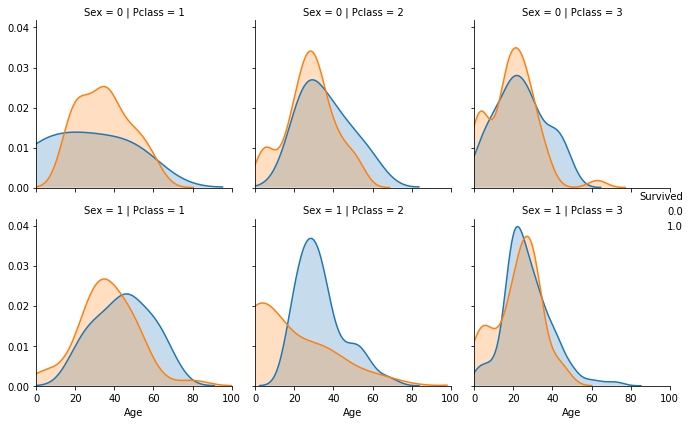

In [19]:
kde_age= sns.FacetGrid(train_df, col='Pclass', row='Sex', hue='Survived')
kde_age.add_legend().set(xlim=(0, 100))
kde_age = kde_age.map(sns.kdeplot, 'Age', shade=True)

Uma possibilidade para completar as informações de idade é preenche-las com a mediana das idades, mas este valor pode variar em função de diferentes grupos de pessoas. Vale checar as features "Family" e "Pclass", que são bem correlacionadas com "Age":

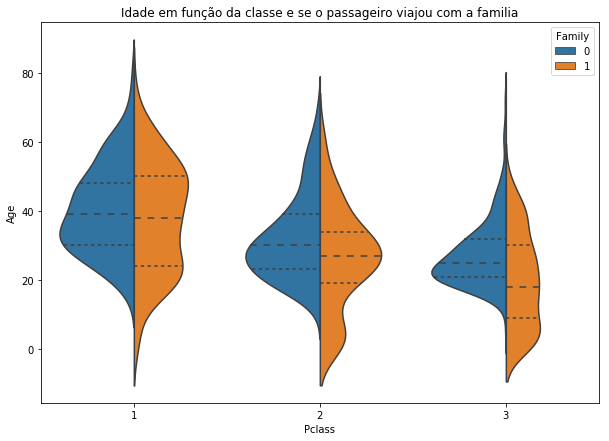

In [20]:
plt.figure(figsize = (10, 7))
plt.title('Idade em função da classe e se o passageiro viajou com a familia')
sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Family', data = all_data, split = True, inner="quartile")
plt.show()

**<font size="5">Preenchendo missing values</font>**

Assim como esperado, diferentes grupos possuem diferentes distribuições de idades, e uma vez que possuimos estas informações, é melhor fazer o preenchimento de forma condicionada:

In [21]:
matriz_de_medianas = np.zeros((2,3))

for classe in range(1, 4):
    for familia in range(0, 2):
        matriz_de_medianas[familia, classe - 1] = all_data.loc[(all_data['Pclass'] == classe) & (all_data['Family'] == familia)]['Age'].median()
        
        all_data.loc[(np.isnan(all_data['Age'])) 
                     & (all_data['Family'] == familia) 
                     & (all_data['Pclass'] == classe), 'Age'] = matriz_de_medianas[familia, classe - 1]

medianas = pd.DataFrame(matriz_de_medianas, columns=[1, 2, 3]); medianas.index.name = 'Family'; medianas.columns.name = 'Pclass'
medianas

Pclass,1,2,3
Family,,,
0,39.0,30.0,25.0
1,38.0,27.0,18.0


In [22]:
# O mesmo é realizado para preencher o único valor nulo da feature "Fare":
all_data.loc[np.isnan(all_data['Fare'])]

,Age,Cabin,Embarked,Fare,Pclass,Sex,Survived,Title,random,Family
152,60.5,0,0,NaN,3,1,NaN,0,0,0


In [23]:
# Preenchendo o valor nulo com a mediana das tarifas deste grupo de indivíduos
all_data.loc[np.isnan(all_data['Fare'])] = all_data.loc[(all_data['Pclass'] == 3) & (all_data['Sex'] == 1) & (all_data['Family'] == 0)]['Fare'].median()

In [24]:
# Nossos dados estão finalmente organizados, limpos e transformados:
all_data.head()

,Age,Cabin,Embarked,Fare,Pclass,Sex,Survived,Title,random,Family
0,22.0,0.0,0.0,7.2500,3.0,1.0,0.0,0.0,0.0,1.0
1,38.0,1.0,2.0,71.2833,1.0,0.0,1.0,0.0,0.0,1.0
2,26.0,0.0,0.0,7.9250,3.0,0.0,1.0,0.0,1.0,0.0
3,35.0,1.0,0.0,53.1000,1.0,0.0,1.0,0.0,0.0,1.0
4,35.0,0.0,0.0,8.0500,3.0,1.0,0.0,0.0,1.0,0.0


**<font size="5">Modelagem e predição</font>**

In [25]:
# Split
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

train_data = train_df.drop("Survived", axis=1)
train_target = train_df["Survived"]
X_test  = test_df.drop("Survived", axis=1)
train_data.shape, train_target.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [26]:
def treina_e_testa_modelo(modelo, dados_de_treino, rotulo, cross_validation_folders):
    
    modelo.fit(dados_de_treino,rotulo)
    
    score = cross_val_score(modelo,
                            dados_de_treino,
                            rotulo,
                            cv=cross_validation_folders).mean()
    
    model_name = str(modelo).split('(')[0]
    
    print(model_name + ' accuracy: '+str(round(score.mean() * 100, 2))+'%')
    
    return score

In [27]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn_score = treina_e_testa_modelo(knn, train_data, train_target, 5)

KNeighborsClassifier accuracy: 70.83%


In [28]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=2020)
random_forest_score = treina_e_testa_modelo(random_forest, train_data, train_target, 5)

RandomForestClassifier accuracy: 80.93%


In [29]:
logreg = LogisticRegression(solver='newton-cg', random_state=2020)
logreg_score = treina_e_testa_modelo(logreg, train_data, train_target, 5)

LogisticRegression accuracy: 79.91%


In [30]:
svc = SVC(gamma='scale', random_state=2020)
svc_score = treina_e_testa_modelo(svc, train_data, train_target, 5)

SVC accuracy: 66.9%


**<font size="5">Compreendendo os resultados</font>**

Random forest e logistic regression foram os modelos mais acertivos, com aproximadamente 80% de acurácia, o próximo passo é utilizar alguns métodos para tentar compreender quais são as features mais importantes para cada um e entender seu funcionamento.

In [31]:
def importance_plot(x_name,y_name, dados, graph_title):
    sns.barplot(x = x_name, y = y_name, data = dados, orient = 'h', color = 'royalblue').set_title(graph_title, fontsize = 20);
    plt.show()

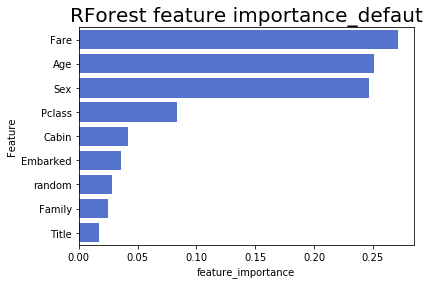

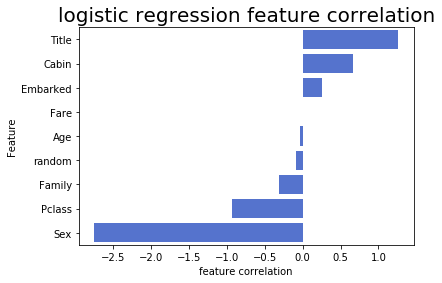

In [32]:
feature_importance_df = pd.DataFrame({'Feature': train_data.columns, 'feature_importance': random_forest.feature_importances_})\
                          .sort_values('feature_importance', ascending = False)

coeff_df = pd.DataFrame({'Feature': train_data.columns, 'feature correlation': pd.Series(logreg.coef_[0])})\
             .sort_values('feature correlation', ascending = False)

importance_plot('feature_importance', 'Feature', feature_importance_df, 'RForest feature importance_defaut')
importance_plot('feature correlation', 'Feature', coeff_df, 'logistic regression feature correlation')

**<font size="3">Observações</font>**:
- Para o algoritmo de regressão logistica a feature 'random' foi apontada como mais correlacionada com a sobrevivência do que a idade e a tarifa, sabemos que isso não faz sentido, mas já era esperado pelo fato de que este modelo não lida com variáveis contínuas como estas.

- Já para o random forest, notamos que 'random' é apontada como mais importante que a família e o título, o que também não faz muito sentido. Frente a isso existem duas possibilidade; estas três features não contribuem muito para o modelo e devem ser descartadas, ou o método ".feature_importances_" não é muito acurado. Este último ponto é confirmado pela literatura, que o aponta como enviesado, pois infla o impacto de features contínuas e de alta cardinalidade.

- Uma possibilidade é testar métodos recursivos, que são muito mais acertivos e computacionalmente caros, o que não representa um problema para um conjunto de dados pequeno como este.

In [33]:
rforest_clone = clone(random_forest)
logreg_clone = clone(logreg)
rf_impact = [] #rf = random forest
lr_impact = [] #lr = logistic regression

for feature in train_data.columns:
    
    rf_new_score = cross_val_score(rforest_clone, train_data.drop(feature, axis=1), train_target, cv=5).mean()
    lr_new_score = cross_val_score(logreg_clone, train_data.drop(feature, axis=1), train_target, cv=5).mean()
    
    rf_impact.append(random_forest_score - rf_new_score)
    lr_impact.append(logreg_score - lr_new_score)

rforest_impact = pd.DataFrame(data={'Feature': train_data.columns, 'Impact': rf_impact}).sort_values('Impact', ascending = False)
logreg_impact = pd.DataFrame(data={'Feature': train_data.columns, 'Impact': lr_impact}).sort_values('Impact', ascending = False)

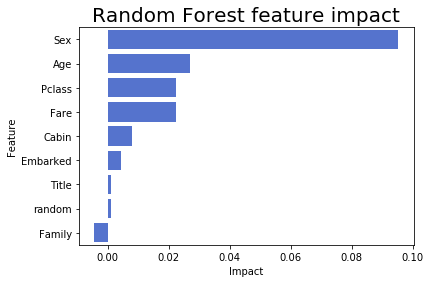

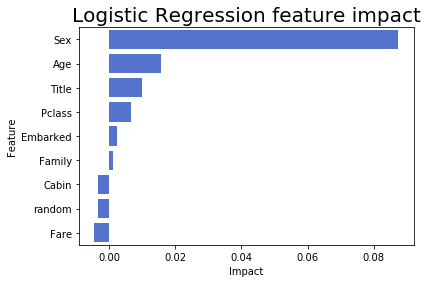

In [34]:
importance_plot('Impact', 'Feature', rforest_impact, 'Random Forest feature impact')
importance_plot('Impact', 'Feature', logreg_impact, 'Logistic Regression feature impact')

- Métodos recursivos são mais acurados e permitem analizar com mais claresa se determiandas features são relevantes para o modelo.

- Para o random forest, fare e age parecem menos relevantes do que o antigo método sugeria e as features "Title", "random" e "Family" contribuem muito pouco ou até o atrapalham, rmeovê-las pode beneficiar o modelo deixando-o mais rapido e evitando overfiting.

- O mesmo vale para a regressão logística, mas em relação as features "Cabin", "random" e "Fare".

**<font size="5">Eliminando features e subimetendo predições</font>**

In [35]:
random_forest_score = treina_e_testa_modelo(random_forest, train_data.drop(['Title', 'random', 'Family'], axis=1), train_target, 10)

RandomForestClassifier accuracy: 81.61%


In [36]:
logreg_forest_score = treina_e_testa_modelo(logreg, train_data.drop(['Cabin', 'random', 'Fare'], axis=1), train_target, 10)

LogisticRegression accuracy: 81.03%


In [37]:
predict = logreg.predict(X_test.drop(['Cabin', 'random', 'Fare'], axis=1)).astype(int)
submission = pd.DataFrame()
submission['PassengerId'] = Id_test
#get predictions
submission['Survived'] = predict
submission.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PassengerId,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906
Survived,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1


In [38]:
submission.to_csv('logreg_submission.csv', index=False)

**Boa parte dos insights mais relevantes para a resolução do problema não partiram de mim. Tenho muito a agredecer pelo trabalho de vários DSs mais experientes da comunidade que compartilharam suas ideias, principalmente através destes notebooks e links:**

- https://www.kaggle.com/alexisbcook/titanic-tutorial

- https://www.kaggle.com/startupsci/titanic-data-science-solutions

- https://www.kaggle.com/omarelgabry/a-journey-through-titanic

- https://www.kaggle.com/tuckerarrants/titanic-ml-top-10

- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e